In [1]:
import numpy
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from importlib import reload
import InputList
import BinaryReader
import Preprocessor
import models
import Callbacks

2022-02-07 18:36:55.122282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [13]:
reload(Preprocessor)

<module 'Preprocessor' from '/home/juliusmlcaesar/PycharmProjects/oct-classifier/Preprocessor.py'>

## Make this such that it can be used for prediction and training pipeline

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
reader = BinaryReader.BinaryReader()  # TODO: Normalizer
training_dataset, validation_dataset = reader.create_training_datasets(InputList.training_files)
preprocesser = Preprocessor.Preprocessor(training_dataset)

Num GPUs Available:  2


In [16]:
print("Creating Normalization Layer:")
normalization_layer = preprocesser.normalize_layer()

Creating Normalization Layer:


In [ ]:
normalization_weights = normalization_layer.get_weights()
print("Before:" + str(normalization_weights))
normalization_weights_path = "results/normalization.npy"
np.save(normalization_weights_path, normalization_weights)
normalization_layer.set_weights(np.load(normalization_weights_path))
print("After" + str(normalization_weights))

In [17]:
normalization_layer.set_weights(np.array([32743.002, 5470130.0, 25706913792]))

In [18]:
model = models.classiRaw3D(training_dataset.element_spec[0].shape, normalization_layer)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536, 23, 28, 1)] 0         
_________________________________________________________________
normalization_2 (Normalizati (None, 1536, 23, 28, 1)   3         
_________________________________________________________________
permute (Permute)            (None, 1, 23, 28, 1536)   0         
_________________________________________________________________
dense (Dense)                (None, 1, 23, 28, 768)    1179648   
_________________________________________________________________
permute_1 (Permute)          (None, 768, 23, 28, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 768, 23, 28, 32)   896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 384, 11, 14, 32)   0     

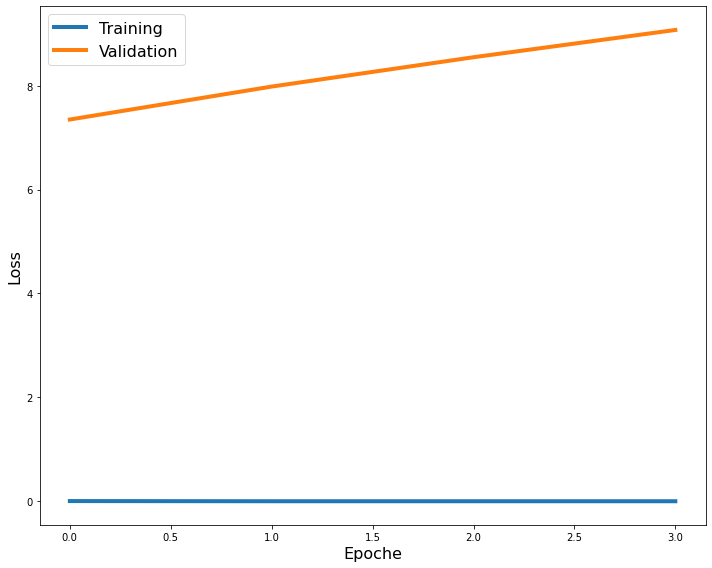

Epoch 5/30
2599/2599 [==============================] - ETA: 0s - loss: 7.1100e-11 - sparse_categorical_crossentropy: 7.1100e-11

In [ ]:
history = model.fit(
    preprocesser.batch(20),
    epochs=30,
    validation_data=Preprocessor.Preprocessor(validation_dataset).batch(20),
    callbacks=Callbacks.my_callbacks
)
model.save('savedModels/first')

In [224]:
training_dataset

<PrefetchDataset shapes: ((1536, 23, 28, 1), ()), types: (tf.uint16, tf.uint8)>

In [8]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [50]:
model.load_weights('checkpoints/best_model.data-00000-of-00001')

OSError: SavedModel file does not exist at: checkpoints/best_model.data-00000-of-00001/{saved_model.pbtxt|saved_model.pb}

print_function(Bag Number, dataset)

-> In einem Bag sind 7000 Instanzen

# Bag Level Model:

Ich hab ganz viele Softmaxes und von denen nehm ich einfach den Max Wert

In [58]:
test_dataset = reader.create_test_dataset([InputList.healthy_training_files[0]])
output = model.predict(test_dataset.batch(20))

KeyboardInterrupt: 

Linearisierung: